# Support Vector Classification (SVC) — Theory & Interview Q&A

Support Vector Classification is a supervised learning algorithm that finds the optimal hyperplane to separate classes, maximizing the margin between support vectors.

| Aspect                | Details                                                                 |
|-----------------------|------------------------------------------------------------------------|
| **Definition**        | Finds the best boundary (hyperplane) to separate classes.               |
| **Equation**          | Decision function: f(x) = w·x + b                                      |
| **Use Cases**         | Text classification, image recognition, bioinformatics                  |
| **Assumptions**       | Data is (mostly) linearly separable, kernel trick for non-linear        |
| **Pros**              | Effective in high dimensions, robust to outliers, kernel flexibility    |
| **Cons**              | Slow for large datasets, sensitive to parameter tuning                  |
| **Key Parameters**    | Kernel, C (regularization), gamma                                      |
| **Evaluation Metrics**| Accuracy, Precision, Recall, F1-score                                   |

## Interview Q&A

**Q1: What is a support vector?**  
A: Data points closest to the decision boundary that influence its position.

**Q2: What is the kernel trick?**  
A: It allows SVC to find non-linear boundaries by mapping data to higher dimensions.

**Q3: What does the parameter C control?**  
A: The trade-off between maximizing margin and minimizing classification error.

**Q4: When should you use SVC?**  
A: For small to medium datasets with complex boundaries.

**Q5: How do you choose the kernel?**  
A: Try linear, polynomial, or RBF kernels based on data characteristics.

**Q6: What is the margin in SVC?**  
A: The distance between the decision boundary and the closest support vectors.

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best Params: {'svc__C': 0.1, 'svc__degree': 2, 'svc__gamma': 'scale', 'svc__kernel': 'linear'}
Best CV ROC AUC: 0.9957
Test Accuracy : 0.9825
Test Precision: 0.9861
Test Recall   : 0.9861
Test F1-Score : 0.9861
Test ROC AUC  : 0.9937

Classification Report:
               precision    recall  f1-score   support

   malignant       0.98      0.98      0.98        42
      benign       0.99      0.99      0.99        72

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114

CV Accuracy (mean ± std): 0.9758 ± 0.0108


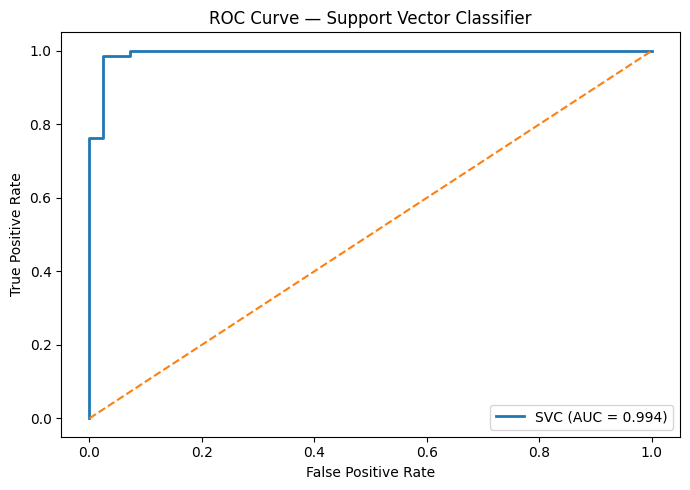

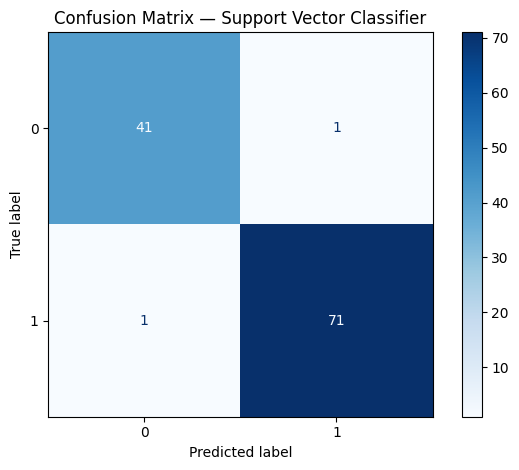

In [4]:
# 09_support_vector_classification.py
# SVC with Pipeline, Hyperparameter Tuning (GridSearchCV), and Cross-Validation

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, ConfusionMatrixDisplay, classification_report
)

# 1) Data acquisition
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name="target")

# 2) Train/Test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 3) Pipeline (scaling -> SVC with probability for ROC/AUC)
pipe = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("svc", SVC(probability=True))
])

# 4) Hyperparameter space
param_grid = {
    "svc__kernel": ["rbf", "linear", "poly"],
    "svc__C": [0.1, 1, 10, 100],
    "svc__gamma": ["scale", "auto"],              # used by rbf/poly; ignored by linear
    "svc__degree": [2, 3]                         # only relevant for poly
}

# 5) Cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 6) Grid search optimized on ROC AUC (robust for class imbalance)
grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    verbose=1
)

# 7) Fit grid search
grid.fit(X_train, y_train)
best_model = grid.best_estimator_

print("Best Params:", grid.best_params_)
print("Best CV ROC AUC:", f"{grid.best_score_:.4f}")

# 8) Holdout performance
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

acc  = accuracy_score(y_test, y_pred)
pre  = precision_score(y_test, y_pred)
rec  = recall_score(y_test, y_pred)
f1   = f1_score(y_test, y_pred)
auc  = roc_auc_score(y_test, y_prob)

print(f"Test Accuracy : {acc:.4f}")
print(f"Test Precision: {pre:.4f}")
print(f"Test Recall   : {rec:.4f}")
print(f"Test F1-Score : {f1:.4f}")
print(f"Test ROC AUC  : {auc:.4f}\n")

print("Classification Report:\n", classification_report(y_test, y_pred, target_names=data.target_names))

# 9) Cross-validated accuracy snapshot (optional governance signal)
cv_acc = cross_val_score(best_model, X_train, y_train, scoring="accuracy", cv=cv, n_jobs=-1)
print("CV Accuracy (mean ± std): {:.4f} ± {:.4f}".format(cv_acc.mean(), cv_acc.std()))

# 10) ROC Curve visualization
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, lw=2, label=f"SVC (AUC = {auc:.3f})")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Support Vector Classifier")
plt.legend()
plt.tight_layout()
plt.show()

# 11) Confusion Matrix visualization
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test, cmap="Blues")
plt.title("Confusion Matrix — Support Vector Classifier")
plt.tight_layout()
plt.show()


c:\Users\Suraj Khodade\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


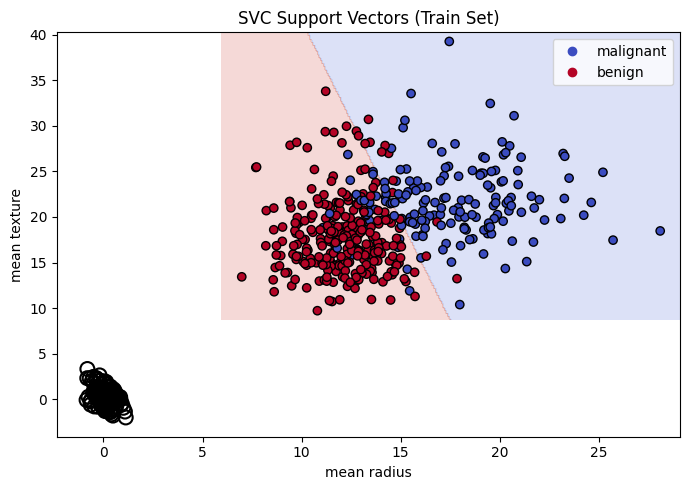

In [5]:
## Plot Support vector
# Select two features for visualization
feat1, feat2 = 'mean radius', 'mean texture'
X_vis = X_train[[feat1, feat2]]
y_vis = y_train

# Fit SVC on selected features
svc_vis = Pipeline([
    ("scaler", StandardScaler()),
    ("svc", SVC(kernel=best_model.named_steps['svc'].kernel,
                 C=best_model.named_steps['svc'].C,
                 gamma=best_model.named_steps['svc'].gamma,
                 degree=best_model.named_steps['svc'].degree,
                 probability=True))
])
svc_vis.fit(X_vis, y_vis)

# Plot decision boundary and support vectors
plt.figure(figsize=(7,5))
# Create mesh grid
x_min, x_max = X_vis[feat1].min() - 1, X_vis[feat1].max() + 1
y_min, y_max = X_vis[feat2].min() - 1, X_vis[feat2].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300), np.linspace(y_min, y_max, 300))
Z = svc_vis.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.2, cmap=plt.cm.coolwarm)

# Plot training points
scatter = plt.scatter(X_vis[feat1], X_vis[feat2], c=y_vis, cmap=plt.cm.coolwarm, edgecolors='k')
plt.xlabel(feat1)
plt.ylabel(feat2)
plt.title('SVC Support Vectors (Train Set)')
# Map unique y_vis values to class names for legend
handles = scatter.legend_elements()[0]
unique_classes = np.unique(y_vis)
labels = [data.target_names[cls] for cls in unique_classes]
plt.legend(handles=handles, labels=labels)

# Plot support vectors
sv = svc_vis.named_steps['svc'].support_vectors_
plt.scatter(sv[:, 0], sv[:, 1], s=100, facecolors='none', edgecolors='k', linewidths=1.5, label='Support Vectors')
plt.tight_layout()
plt.show()
